# The Hockey Problem

In this notebook, I will explore data from the NHL (National Hockey League), which is a professional ice hockey league in North America (comprising teams from US and Canada). 

For this exercise, we have two sources of data:
1. https://www.scrapethissite.com/pages/forms
2. http://www.espn.com/nhl/statistics

I tried to structure this notebook in a way it follows my thinking process :) 

# Libraries

In [9]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 18})

# Reading data

### Web scrapping

In order to get the database of NHL team stats, let's use a web scraper using Beautiful Soup. For this, I modified the code from https://github.com/turing-usp/Trainee-DS-2021/blob/main/Scraping.ipynb.

In [10]:
def clean_names(names):
    """Clean line breaks \n 

    Keyword arguments:
    names -- list of names to be cleaned
    """
    
    name_list = []
    for i in range(len(names)):
        name = names[i].text.split()[0]
        for j in np.arange(1, len(names[i].text.split())):
            name = name + " " + names[i].text.split()[j]
        name_list.append(name)
    return name_list

In [11]:
data = pd.DataFrame()
for num_pag in range(6):
    link = "https://scrapethissite.com/pages/forms/?page_num="+str(num_pag+1)+"&per_page=100"

    source= requests.get(link).text

    soup=BeautifulSoup(source,'html.parser')

    table = soup.find_all('table',class_='table')[0]

    names = table.find_all('td', class_='name')
    years = table.find_all('td', class_='year')
    wins = table.find_all('td', class_='wins')
    losses = table.find_all('td', class_='losses')
    ot_losses = table.find_all('td', class_='ot-losses')
    win_rates = table.find_all('td', class_ ='pct text-success')
    gfs = table.find_all('td', class_= 'gf')
    gas = table.find_all('td', class_= 'ga')
    diffs = table.find_all('td', class_= 'diff text-success')


    names_list = []
    years_list = []
    wins_list = []
    losses_list = []
    ot_list = []
    gfs_list = []
    gas_list = []

    names_list = clean_names(names)   

    for i in range(len(names)):
        years_list.append(int(years[i].text))
        wins_list.append(int(wins[i].text))
        losses_list.append(int(losses[i].text))
        gfs_list.append(int(gfs[i].text))
        gas_list.append(int(gas[i].text))

        try:
            ot_list.append(ot_losses[i].text.replace("\n","").replace(" ", ""))
        except:
            ot_list.append('NaN')

    data_keys = {"Team": names_list, 'Year': years_list, 'OT Losses': ot_list, 
                "GF": gfs_list, "GA": gas_list, "Wins": wins_list, "Losses": losses_list}

    data = pd.concat([data, pd.DataFrame.from_dict(data_keys)], ignore_index=True)


In [12]:
data["Win_rate"] = (data["Wins"] / (data["Wins"] + data["Losses"]))
data["Diff"] = data["GF"] - data["GA"]


In [13]:
# Uncomment line below to check data:
# data

### ESPN data

In [14]:
# Reading ESPN data
data_espn = pd.read_table("DataSet ESPN.csv", sep=",", index_col=[0])

In [15]:
# Uncomment line below to check ESPN data:
# data_espn

# Data Cleaning

Let me be clear:

1. I know nothing about ice hockey and NHL (actually, few things that I know come perhaps from watching Mighty Ducks as a kid...)
2. I know almost nothing about these two datasets

Therefore, one reading this notebook will join me in this journey of discovering ice hockey through data.


Ok, let's recap what we have:

1. data: dataframe containing information from https://www.scrapethissite.com/pages/forms 
2. data_espn: dataframe containing information from http://www.espn.com/nhl/statistics

And this is the information that I have about the ESPN data columns:

1. Team: name of the team
2. Home Games: number of games at home 
3. Home Total: total number of fans (all games in that year) at home games
4. Home Average: mean number of fans per home game 
5. Road Games: number of games played out of home 
6. Road Average: mean number of fans per game played out of home
7. Overall Games: total number of games played
8. Overall Average: mean number of fans per game (considering all games played)
9. Year: year that the season has ended 
10. Save Percentage: percentage of saves (i.e. avoiding score from the opposing team)
11. Penalty Minutes: minutes of penalty that the team has suffered
12. Penalty Minutes Against: minutes of penalty that the opposing team has suffered



## Cross-matching the datasets

First of all, I want to check if the two datasets can be cross-matched, i.e. if the two datasets comprise information from the same team in the same year season.

In [16]:
data.Year.value_counts()

2000    30
2001    30
2010    30
2009    30
2008    30
2007    30
2006    30
2005    30
2003    30
2002    30
2011    30
1999    28
1998    27
1997    26
1996    26
1995    26
1994    26
1993    26
1992    24
1991    22
1990    21
Name: Year, dtype: int64

In [17]:
data_espn.Year.value_counts()

2001    29
2002    29
2003    29
2004    29
2006    29
2007    29
2008    29
2009    29
2010    29
2011    29
Name: Year, dtype: int64

We double-checked the information in the [ESPN website](https://www.espn.com/nhl/stats/team/_/view/goaltending/season/2009/seasontype/2/table/defensive/sort/savePct/dir/desc) to see if it matches with the information from the web scrapping. From this, we see that the Year column in *data* is the year of the beginning of the season. Meanwhile, *data_espn* gives us the year of the ending of the season. So let's fix that by adding +1 to the Year column in *data*.

In [18]:
data["Year"] = data["Year"]+1

Let's also check if there are any duplicate entries for the same team in the same year:

In [19]:
if len(data[data.duplicated(subset=['Team','Year'])])==0:
    print("There are no duplicate entries for the same team in the same year.")

if len(data_espn[data_espn.duplicated(subset=['Team','Year'])])==0:
    print("There are no duplicate entries for the same team in the same year.")


There are no duplicate entries for the same team in the same year.
There are no duplicate entries for the same team in the same year.


Now I am going to check if there is any team that is included in only one dataset for each season:

In [372]:
print("Teams that are in data but are not in data_espn:")
for year in data.Year.unique():
    if year in data_espn.Year.unique():
        print(">>> Year:", year)
        for name in data[data["Year"]==year].Team.unique():
            if name not in data_espn[data_espn["Year"]==year].Team.unique():
                print(name)
        print("----------")

print("\nTeams that are in data_espn but are not in data:")
for year in data_espn.Year.unique():
    if year in data.Year.unique():
        print(">>> Year:", year)
        for name in data_espn[data_espn["Year"]==year].Team.unique():
            if name not in data[data["Year"]==year].Team.unique():
                print(name)

Teams that are in data but are not in data_espn:
>>> Year: 2001
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2002
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2003
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2004
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2006
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2007
Anaheim Ducks
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2008
Anaheim Ducks
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2009
Anaheim Ducks
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2010
Anaheim Ducks
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------
>>> Year: 2011
Anaheim Ducks
Atlanta Thrashers
Minnesota Wild
St. Louis Blues
----------

Teams that are in data_espn but are not in data:
>>> Year: 2001
St Louis Blues
Minnesota North Stars
>>> Year: 2002
St Louis Blues

From the exercise above, we see that the St Louis Blues team are spelled in a different way in both datasets. Let's fix that:

In [373]:
data_espn.replace(to_replace="St Louis Blues", value = "St. Louis Blues", inplace=True)

For the other teams, we need to check a bit further. From wikipedia:

- **Minnesota North Stars**: After the 1992–93 season, the franchise moved to Dallas, and is now known as the Dallas Stars.

- **Minnesota Wild** : The Wild were founded on June 25, 1997, but did not start play until the 2000–01 season. The Wild was the first NHL franchise in Minnesota since the Minnesota North Stars moved to Dallas in 1993. 

- **Mighty Ducks of Anaheim**: The club was founded in 1993 by The Walt Disney Company as the Mighty Ducks of Anaheim, a name based on the 1992 film The Mighty Ducks. Disney sold the franchise in 2005 to Henry and Susan Samueli, who along with then-general manager Brian Burke, changed the name of the team to the Anaheim Ducks before the 2006–07 season.

- **Winnipeg Jets**: The Jets were established as the Atlanta Thrashers on June 25, 1997, and became the League's 28th franchise when they began play in the 1999–2000 NHL season. True North Sports & Entertainment then bought the team in May 2011 and relocated the franchise from Atlanta to Winnipeg prior to the 2011–12 season (the first NHL franchise to relocate since the Hartford Whalers became the Carolina Hurricanes in 1997).

Therefore, we can replace:

In [374]:
data.replace(to_replace="Minnesota North Stars", value="Dallas Stars", inplace=True)
data.replace(to_replace="Anaheim Ducks", value="Mighty Ducks of Anaheim", inplace=True)
data.replace(to_replace="Winnipeg Jets", value="Atlanta Thrashers", inplace=True)


In [375]:
np.sort(data.Team.unique())

array(['Atlanta Thrashers', 'Boston Bruins', 'Buffalo Sabres',
       'Calgary Flames', 'Carolina Hurricanes', 'Chicago Blackhawks',
       'Colorado Avalanche', 'Columbus Blue Jackets', 'Dallas Stars',
       'Detroit Red Wings', 'Edmonton Oilers', 'Florida Panthers',
       'Hartford Whalers', 'Los Angeles Kings', 'Mighty Ducks of Anaheim',
       'Minnesota Wild', 'Montreal Canadiens', 'Nashville Predators',
       'New Jersey Devils', 'New York Islanders', 'New York Rangers',
       'Ottawa Senators', 'Philadelphia Flyers', 'Phoenix Coyotes',
       'Pittsburgh Penguins', 'Quebec Nordiques', 'San Jose Sharks',
       'St. Louis Blues', 'Tampa Bay Lightning', 'Toronto Maple Leafs',
       'Vancouver Canucks', 'Washington Capitals'], dtype=object)

In [376]:
np.sort(data_espn.Team.unique())

array(['Boston Bruins', 'Buffalo Sabres', 'Calgary Flames',
       'Carolina Hurricanes', 'Chicago Blackhawks', 'Colorado Avalanche',
       'Columbus Blue Jackets', 'Dallas Stars', 'Detroit Red Wings',
       'Edmonton Oilers', 'Florida Panthers', 'Los Angeles Kings',
       'Mighty Ducks of Anaheim', 'Minnesota North Stars',
       'Montreal Canadiens', 'Nashville Predators', 'New Jersey Devils',
       'New York Islanders', 'New York Rangers', 'Ottawa Senators',
       'Philadelphia Flyers', 'Phoenix Coyotes', 'Pittsburgh Penguins',
       'San Jose Sharks', 'St. Louis Blues', 'Tampa Bay Lightning',
       'Toronto Maple Leafs', 'Vancouver Canucks', 'Washington Capitals'],
      dtype=object)

We can see from the output above that data_espn have information for both "Dallas Stars" and "Minnesota North Stars".  However, we have seen that these names correspond to the same team. By double-checking the ESPN website, we conclude that "Minnesota North Stars" is mispelled and it should actually be "Minnesota Wild".

In [377]:
data_espn.replace(to_replace="Minnesota North Stars", value="Minnesota Wild", inplace=True)

In [378]:
data

Team  Year OT Losses   GF   GA  Wins  Losses  Win_rate  \
0          Boston Bruins  1991            299  264    44      24  0.647059   
1         Buffalo Sabres  1991            292  278    31      30  0.508197   
2         Calgary Flames  1991            344  263    46      26  0.638889   
3     Chicago Blackhawks  1991            284  211    49      23  0.680556   
4      Detroit Red Wings  1991            273  298    34      38  0.472222   
..                   ...   ...       ...  ...  ...   ...     ...       ...   
577  Tampa Bay Lightning  2012         8  235  281    38      36  0.513514   
578  Toronto Maple Leafs  2012        10  231  264    35      37  0.486111   
579    Vancouver Canucks  2012         9  249  198    51      22  0.698630   
580  Washington Capitals  2012         8  222  230    42      32  0.567568   
581    Atlanta Thrashers  2012        10  225  246    37      35  0.513889   

     Diff  
0      35  
1      14  
2      81  
3      73  
4     -25  
..    ...  
577   -46  
578   -33  
579    51  
580    -8  
581   -21  

[582 rows x 9 columns]

In [379]:
# Let's save the teams list:

team_list = list(data.Team.unique())
for team in data_espn.Team.unique():
    if team not in team_list:
        team_list.append(team)

Now that we have checked the team names, we can set data_espn and data as multi-index dataframes. Both will have "Team" and "Year" as an index. By doing that, concatenating data and data_espn becomes very easy. 

In [380]:
data_espn.set_index(['Team', 'Year'], inplace=True)
data.set_index(['Team', 'Year'], inplace=True)

In [381]:
hockey = pd.concat([data,data_espn], axis=1)

Now let's check the dtypes from our hockey dataset:

In [382]:
hockey.dtypes

OT Losses                   object
GF                           int64
GA                           int64
Wins                         int64
Losses                       int64
Win_rate                   float64
Diff                         int64
Home Games                 float64
Home Total                  object
Home Average                object
Road Games                 float64
Road Average                object
Overall Games              float64
Overall Average             object
Save Percentage            float64
Penalty Minutes            float64
Penalty Minutes Against    float64
dtype: object

Let's fix those columns that are being interpreted as object instead of float64:

In [383]:
for idx, item in enumerate(hockey['OT Losses']):
    try: 
        float(item)
    except:
        hockey['OT Losses'].iloc[idx] = np.nan



/Users/Mariko/opt/anaconda3/envs/turing/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [384]:
for idx, item in enumerate(hockey['Home Total']):
    try:
        hockey['Home Total'].iloc[idx] = float(item.split(",")[0]+item.split(",")[1])
    except:
        pass



In [385]:
for idx, item in enumerate(hockey['Home Average']):
    try:
        hockey['Home Average'].iloc[idx] = float(item.split(",")[0]+item.split(",")[1])
    except:
        pass



In [386]:
for idx, item in enumerate(hockey['Road Average']):
    try:
        hockey['Road Average'].iloc[idx] = float(item.split(",")[0]+item.split(",")[1])
    except:
        pass



In [387]:
for idx, item in enumerate(hockey['Overall Average']):
    try:
        hockey['Overall Average'].iloc[idx] = float(item.split(",")[0]+item.split(",")[1])
    except:
        pass

In [388]:
hockey[["OT Losses", "Home Total", "Home Average", "Road Average", "Overall Average"]] = hockey[["OT Losses", "Home Total", "Home Average", "Road Average", "Overall Average"]].apply(pd.to_numeric)


Let's check dtypes again:

In [389]:
hockey.dtypes

OT Losses                  float64
GF                           int64
GA                           int64
Wins                         int64
Losses                       int64
Win_rate                   float64
Diff                         int64
Home Games                 float64
Home Total                 float64
Home Average               float64
Road Games                 float64
Road Average               float64
Overall Games              float64
Overall Average            float64
Save Percentage            float64
Penalty Minutes            float64
Penalty Minutes Against    float64
dtype: object

In [ ]:
hockey = hockey.sort_index()

# Exploring the data

In this part of the notebook I will try to characterize some trends and correlations. Fitting models are out of scope for this notebook. 

Let's define a function that will plot any column of interest per year for each team:

In [437]:
def plot_grid_per_year(hockey, ycol, team_list = team_list):
    cols= 4
    rows = int(len(team_list)/5)
    fig, axes = plt.subplots(nrows= rows, ncols= cols, figsize=(30,30)) 
    for team, ax in zip(team_list, axes.ravel()):
        x = hockey.loc[(team,)].index
        y = hockey.loc[(team,)][ycol]
        average = np.mean(hockey[ycol]) 
        ax.plot(x, y, 'k--')
        ax.set_title(team)
        ax.set_xlabel("Year")
        ax.set_ylabel(ycol)
        ax.set_title(team)  
        ax.set_ylim(np.min(hockey[ycol]-0.05), np.max(hockey[ycol]+0.05))
        ax.set_xlim(1991,2012)
        ax.axhline(average, color='red')
        ax.fill_between(x, y, average, where = (y >= average) , interpolate=True, color='lightblue', alpha=0.8) # above average in blue
        ax.fill_between(x, average, y, where = (y <= average), interpolate=True, color = 'tomato', alpha=0.8) # below average in red
        ax.scatter(x,y, color="black")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    plt.show()
    return

Let's check, for instance, the win rate of each team:

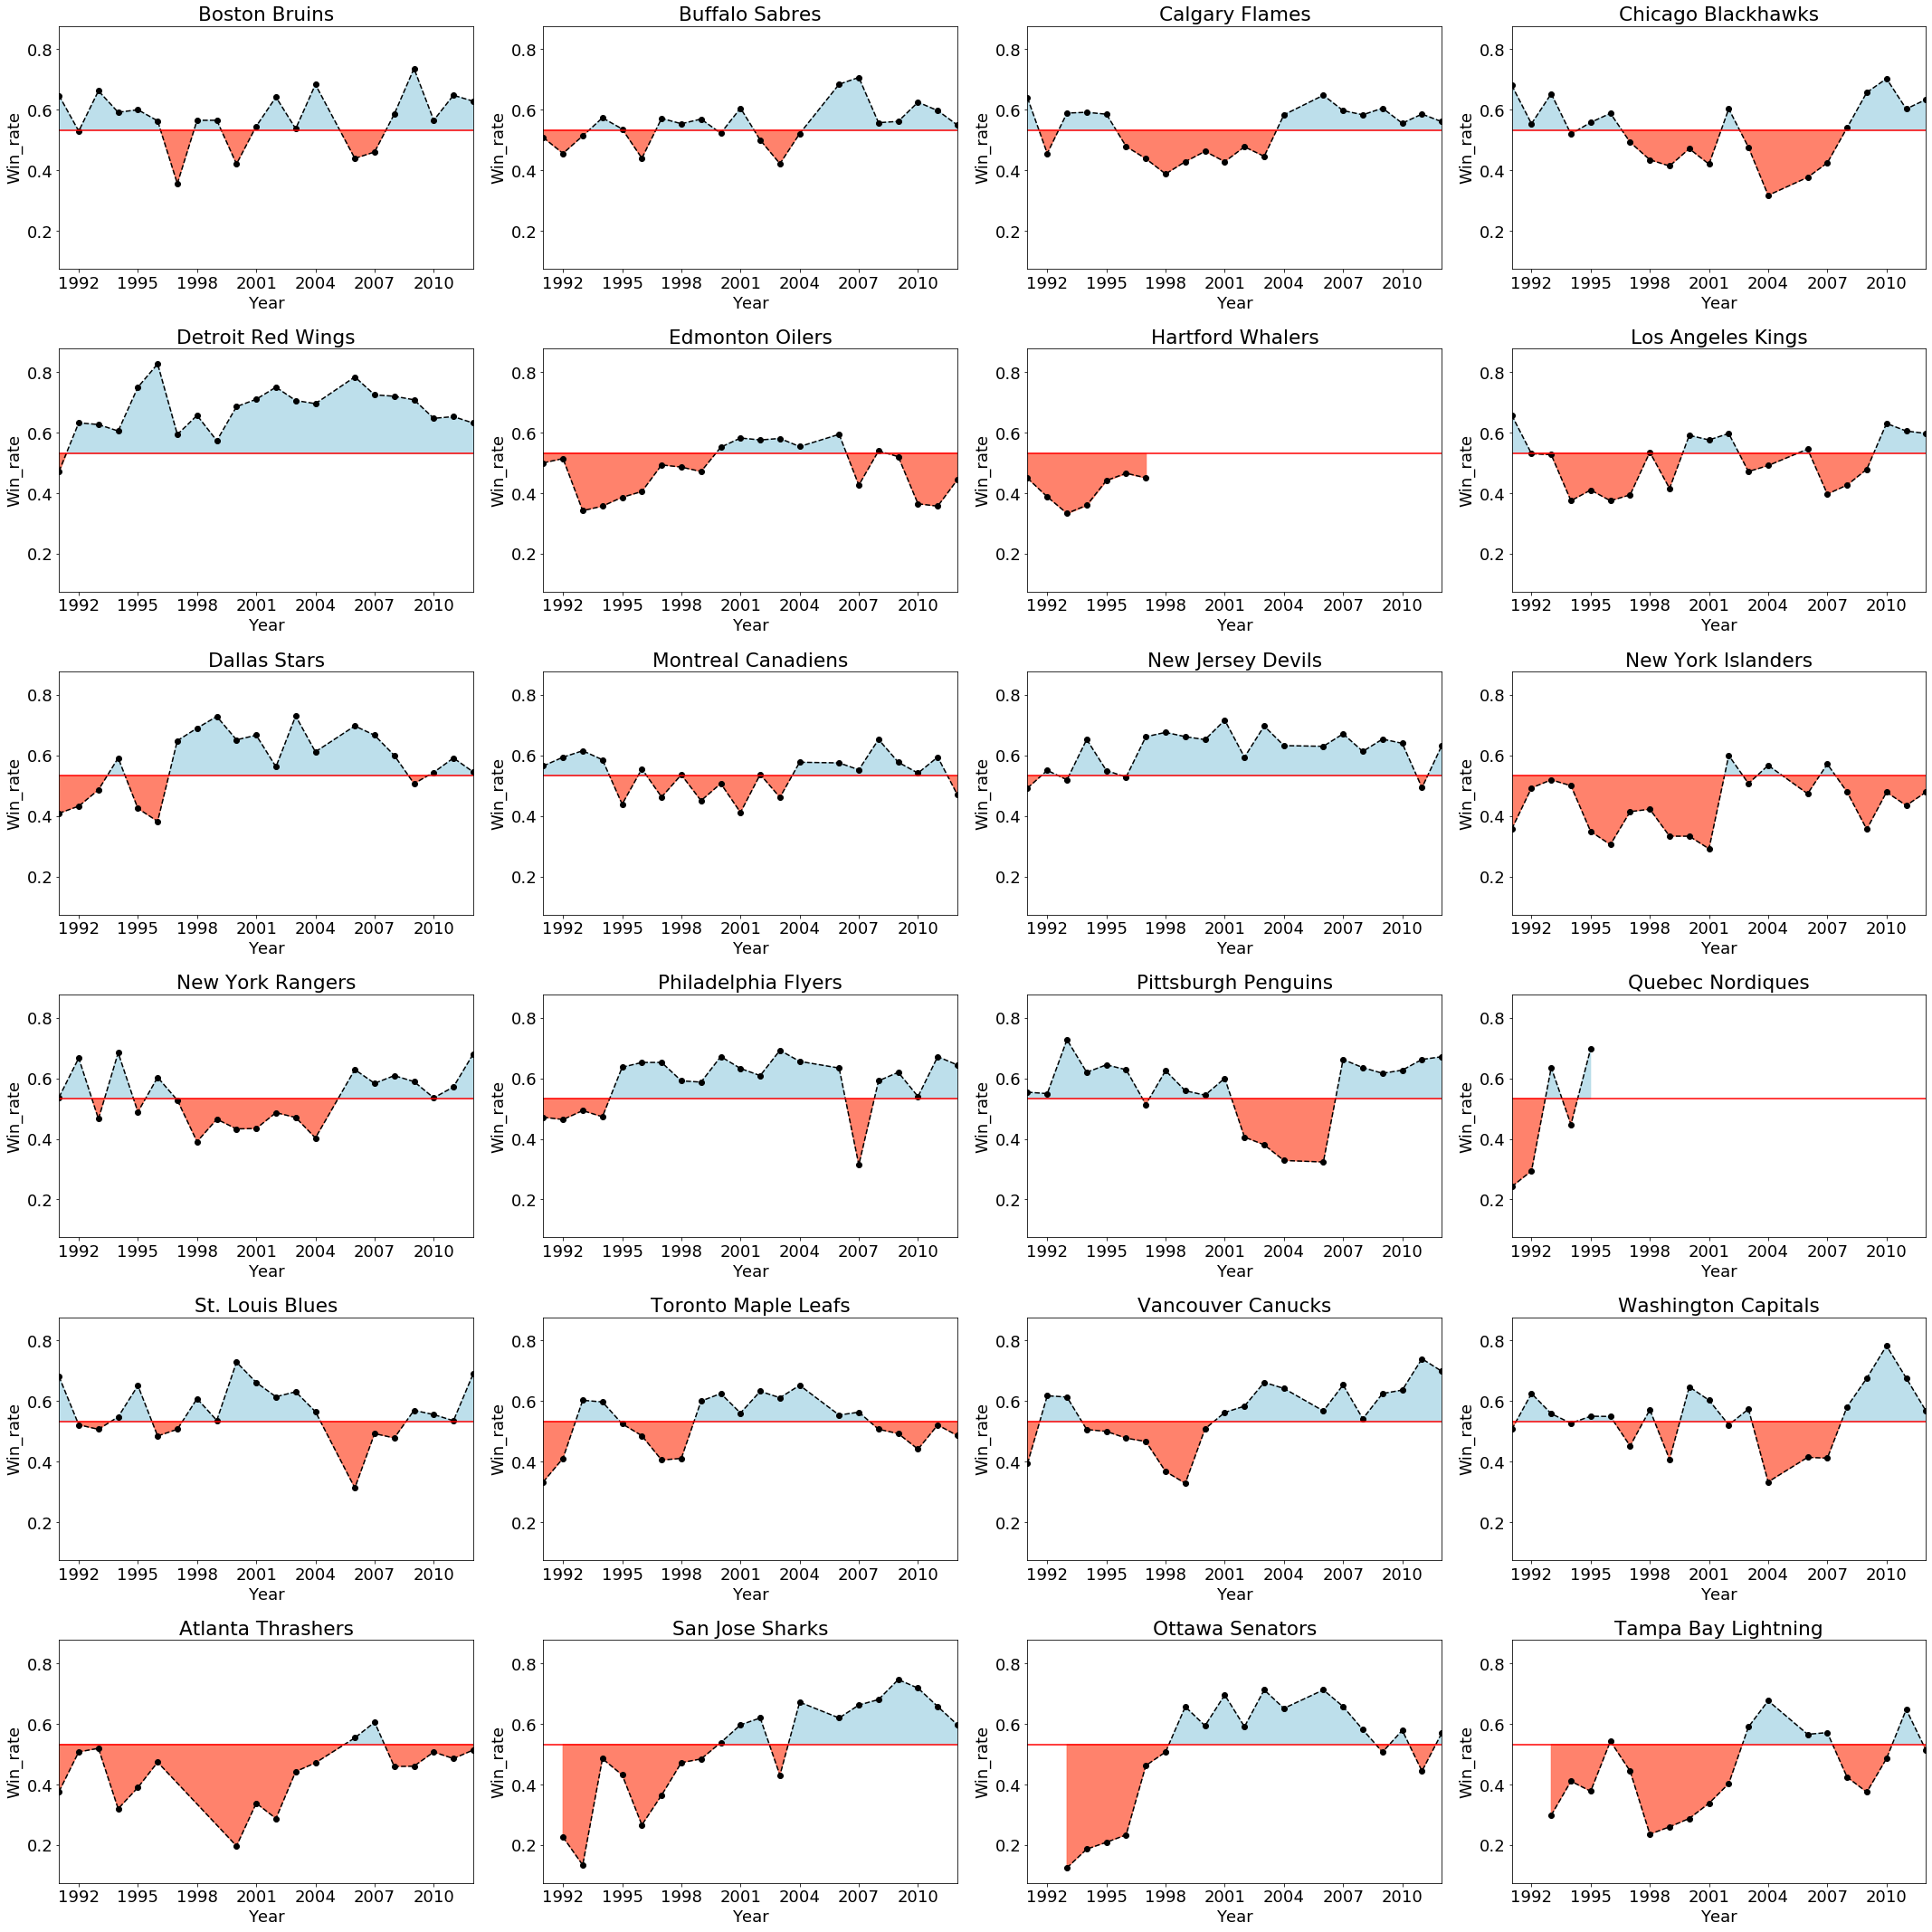

In [438]:
plot_grid_per_year(hockey, 'Win_rate')

We can see that some teams have a bad performance in general, such as Atlanta Thrashers, New York Islanders and Edmont Oileirs. If you are willing to start cheering for a NHL team you would probably like to choose Detroit Red Wings or New Jersey Devils.

Interestingly, although New Jersey Devils perfomed well among the years, they had an overall number of fans per game below average:

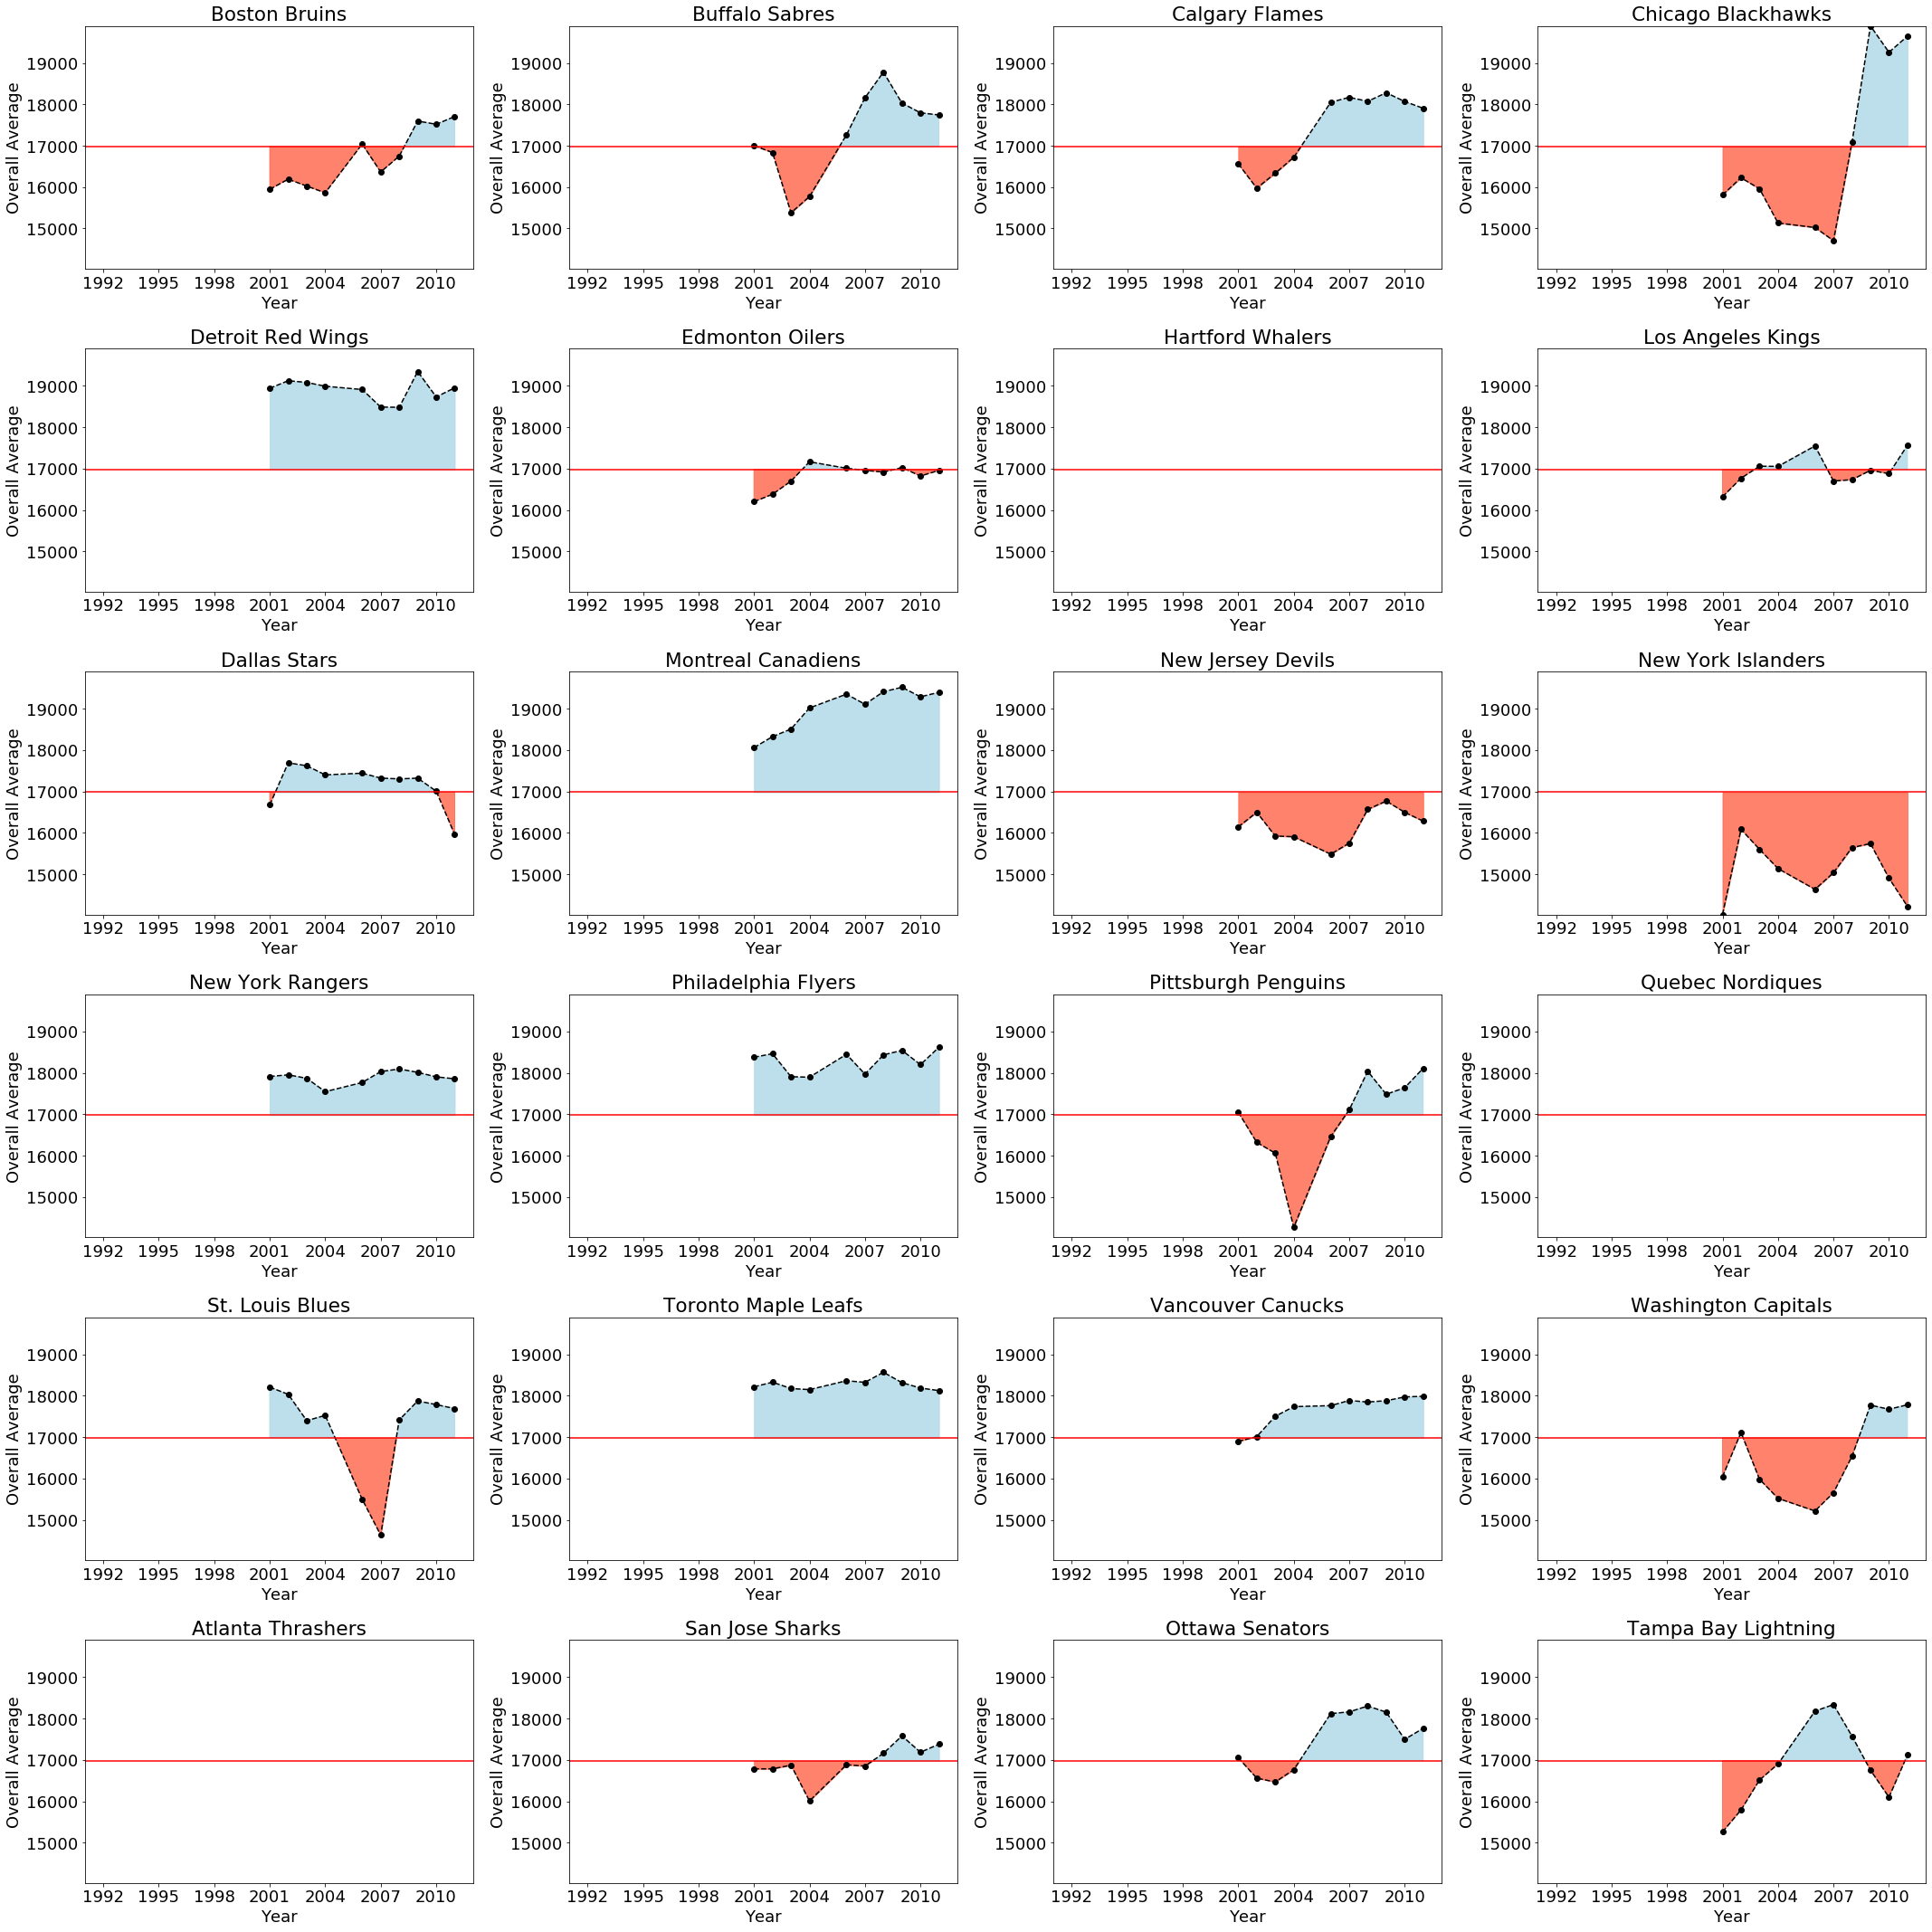

In [439]:
plot_grid_per_year(hockey, 'Overall Average')

While the plots above help us to compare the trends between teams, it is interesting to compare different statistics from the same team. Therefore, let's create another function that will plot some columns of interest for the same team in the same row.

In [482]:
def plot_multiple(hockey, ycol, team_list = team_list):
    cols= len(ycol)
    rows = len(team_list)
    fig, axes = plt.subplots(nrows= rows, ncols= cols, figsize=(8*cols, 120)) 
    for j, yc in enumerate(ycol):
        i=0
        for team in team_list:
            x = hockey.loc[(team,)].index
            y = hockey.loc[(team,)][yc]
            average = np.mean(hockey[yc])
            ax = axes[i,j]
            ax.plot(x, y, 'k--')
            ax.set_title(team)
            ax.set_xlabel("Year")
            ax.set_ylabel(yc)
            ax.set_title(team)  
            ax.set_ylim(np.min(hockey[yc]-np.std(hockey[yc])), np.max(hockey[yc]+np.std(hockey[yc])))
            ax.set_xlim(1991,2013)
            ax.axhline(average, color='red')
            if yc in ["OT Losses", "GA", "Losses", "Penalty Minutes"]:
                ax.invert_yaxis()
            ax.fill_between(x, y, average, where = (y >= average) , interpolate=True, color='lightblue', alpha=0.8)
            ax.fill_between(x, average, y, where = (y <= average), interpolate=True, color = 'tomato', alpha=0.8)
            ax.scatter(x,y, color="black")
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

            i+=1
    plt.tight_layout()
    fig.patch.set_facecolor('xkcd:white')
    plt.show()
    return

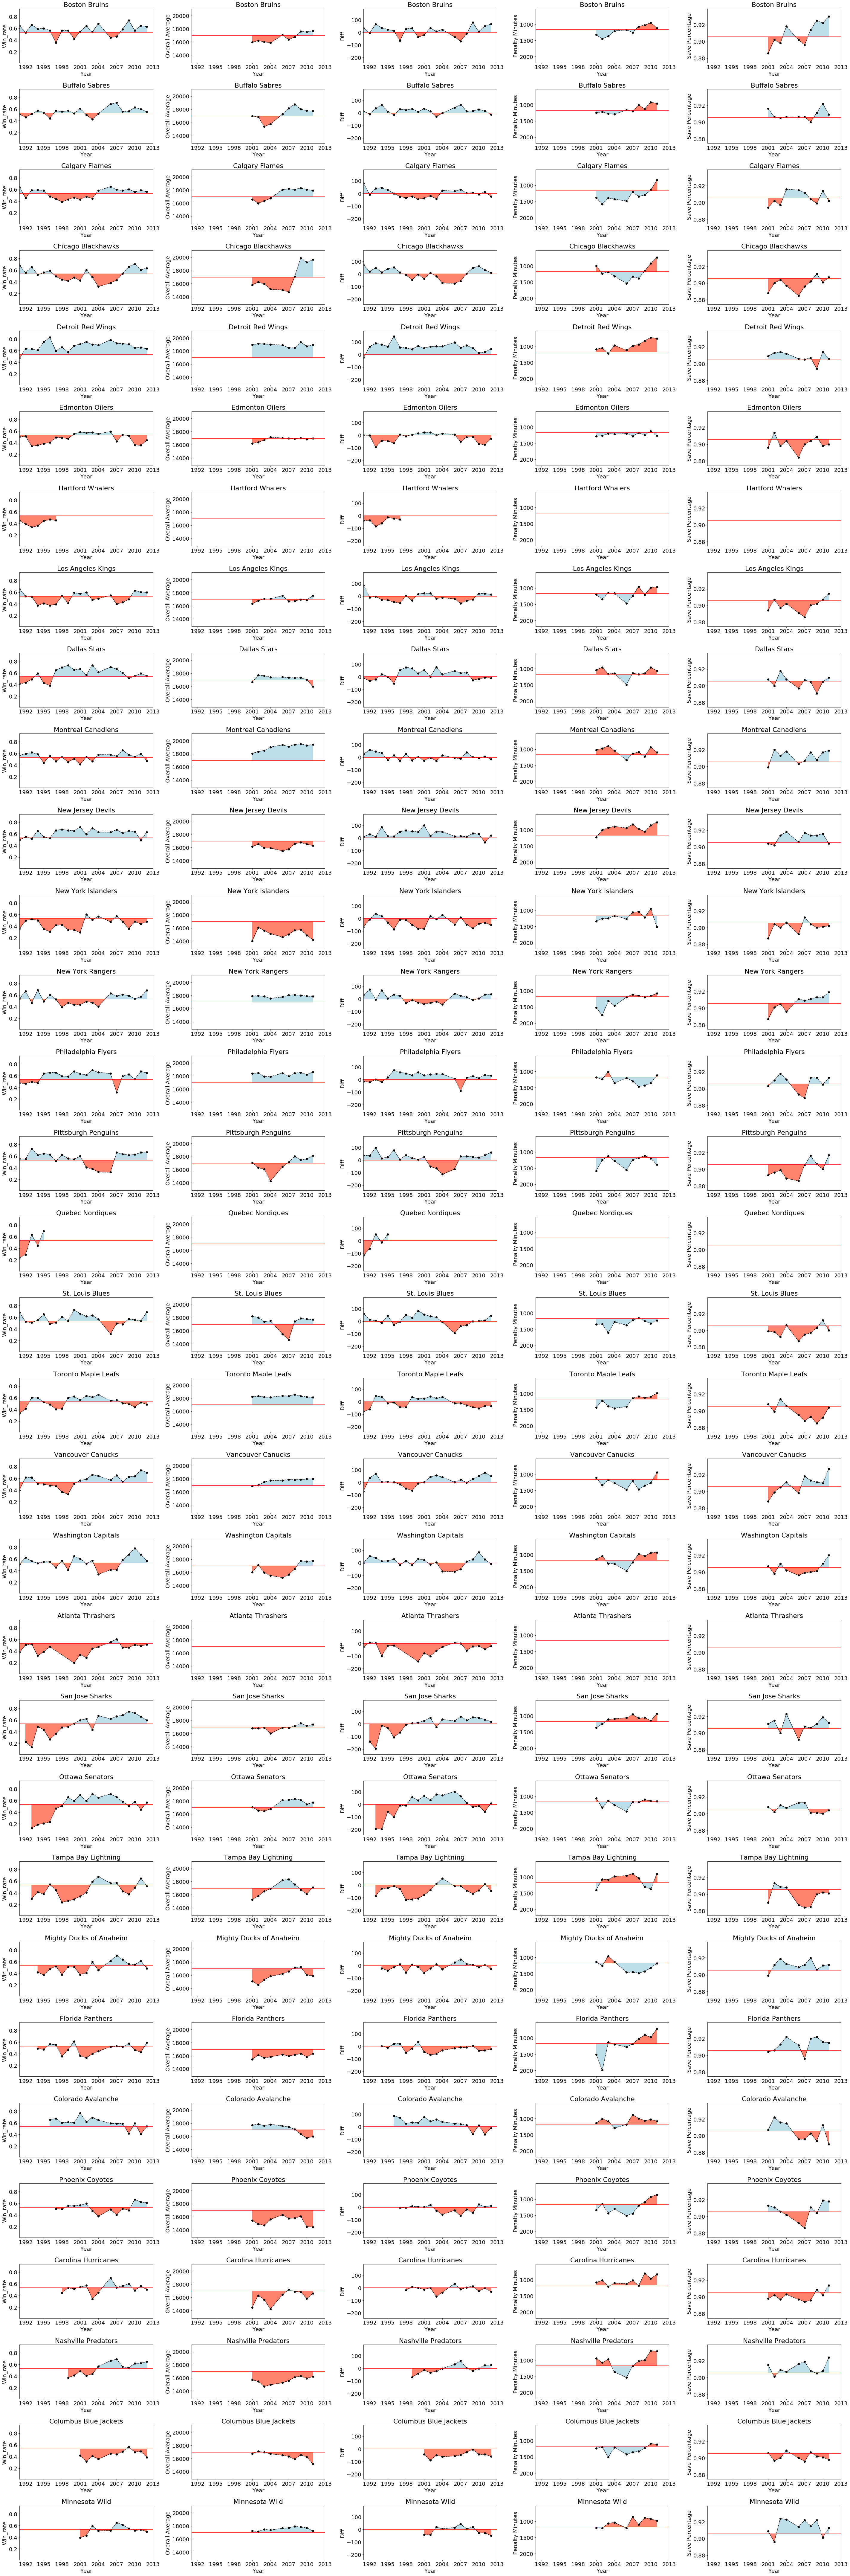

In [483]:
plot_multiple(hockey, ["Win_rate", "Overall Average", "Diff", "Penalty Minutes", "Save Percentage"])

Another way to check correlation between variables is to calculate the Pearson correlation coefficient. However, this can only be calculated among teams that do not present missing values in any considered columns. 

In [498]:
corr = hockey[["Win_rate", "Overall Average", "Diff", "Penalty Minutes", "Save Percentage", "Road Average"]].dropna().corr()  # drop missing values
corr.style.background_gradient(cmap="coolwarm_r", vmin=-1, vmax=1)

The most interesting conclusion we get from these correlations is the medium positive correlation between: 
- win rate and overall number of fans per game (0.439)
- wint rate and save percentage (0.472)
